In [1]:
include("../../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, Printf, LaTeXStrings

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


In [3]:
FILE_F_MAP = "../../test/datatest/F_REFERENCE.txt"
FILE_PS = "../../test/datatest/file_pk.txt"
FILE_BACKGROUND = "../../test/datatest/WideA_ZA_background.dat"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 10.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70,
    N = 1024, fit_min = 0.05, fit_max= 0.5, con=true, s_lim=1.0)

cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP; expand=false)

GaPSE.parameters_used(stdout, cosmo)


I take the input power spectrum as it is,without expanding.
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "../../test/datatest/file_pk.txt"
# F window function input file : "../../test/datatest/F_REFERENCE.txt"
# CLASS Background input file: "../../test/datatest/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 10.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001465757 Mpc/h_0
# 	 comoving s_max = 571.7022420258767 Mpc/h_0
# 	 comoving s_eff = 435.3747095690664 Mpc/h_0
# 	 comoving z_eff = 0.15045636096023224 
# 	 Volume of the survey V_survey = 3.845366167995967e8
# 	 σ_0 = 15.593462966741178
# 	 σ_1 = 15.074895881392285
# 	 σ_2 = 100.85852368830221
# 	 σ_3 = 3735.1227501923527
# 


In [11]:
GaPSE.print_map_ξ_multipole(cosmo, "xi_doppler_L0.txt", "auto_doppler"; 
    use_windows = false, N_μs = 50, N_log=100)

auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:02



time needed for map_integral_on_mu for auto_doppler [in s] = 3.00247 


In [12]:
tab_pk = readdlm(FILE_PS, comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);

In [13]:
my_table = readdlm("xi_doppler_L0.txt", comments=true)
my_ss = convert(Vector{Float64}, my_table[:, 1]);
my_dopplers = convert(Vector{Float64}, my_table[:, 2]);
mattia_table = readdlm("/Users/matteofoglieni/Dropbox/GR_effects/Mattia_Output/Monopoles_without_window/xi_doppler_L0.txt")
mattia_ss = convert(Vector{Float64}, mattia_table[2:end, 1]);
mattia_dopplers = convert(Vector{Float64}, mattia_table[2:end, 2]);

In [ ]:
my_xs = my_ss
my_ys = my_dopplers
xs = mattia_ss
ys = mattia_dopplers
spline = Spline1D(xs, ys)

S_VLIM=cosmo.s_eff

p1 = plot([my_xs, xs], [my_ys,  ys], xaxis=:log, yaxis=:log, lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :solid], legend=:topleft)
vline!(p1, [S_VLIM])

p2 = plot(my_xs, spline.(my_xs) .- my_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
vline!(p2, [S_VLIM])

p3 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, xaxis=:log,
    ylim=(0.99,1.01))
vline!(p3, [S_VLIM])

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

In [ ]:
my_xs = my_ss
my_ys = my_dopplers
xs = mattia_ss
ys = mattia_dopplers
spline = Spline1D(xs, ys)

S_VLIM = cosmo.s_eff
S_VLIM_F = @sprintf("%.2f", S_VLIM)

p1 = plot([my_xs, xs], [my_ys,  ys], xaxis=:log, yaxis=:log, lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :solid], legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, xaxis=:log,
    ylim=(0.99,1.01), legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1}\,\mathrm{Mpc}]$")
vline!(p2, [S_VLIM], label="$S_VLIM_F Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, size=(550, 500), layout= @layout [ x ; z ] )
savefig(P, "xi_AutoDoppler_L0.pdf")
display(P)

In [6]:

calc_xis = [
1.7777752023903378e-6 , 1.6561328120889469e-6 , 1.5997531952004616e-6 , 1.5205744487648466e-6 , 1.5024620486126704e-6 , 1.4472440798253868e-6 , 1.3762283817000443e-6 , 
1.329531094281758e-6 , 1.27918679676945e-6 , 1.2238396637347386e-6 , 1.1780298994230315e-6 , 1.1312332420201405e-6 , 1.0867008505977842e-6 , 1.0429299750560164e-6 , 
1.0008426374618676e-6 , 9.59873073257423e-7 , 9.203970938652744e-7 , 8.818936111834247e-7 , 8.447712545265073e-7 , 8.089552077536156e-7 , 7.742131780320214e-7 , 
7.405976921663026e-7 , 7.080773244765157e-7 , 6.765747972502265e-7 , 6.461192743125857e-7 , 6.164128170527996e-7 , 5.879335417631802e-7 , 5.603930827493593e-7 , 
5.337759276653699e-7 , 5.080610214024985e-7 , 4.832329753500247e-7 , 4.5927480370470247e-7 , 4.361730849509698e-7 , 4.1391860805445694e-7 , 3.9250385012738035e-7 , 
3.7192396062465025e-7 , 3.521769588191401e-7 , 3.3326299999287374e-7 , 3.1518413002817273e-7 , 2.979430914077988e-7 , 2.815420966871942e-7 , 2.659813726749492e-7 , 
2.512569064789357e-7 , 2.3735825787621255e-7 , 2.242663178506448e-7 , 2.1195157957559033e-7 , 2.0037341728608537e-7 , 1.8948077780412891e-7 , 1.7921442223256108e-7 , 
1.695102044710919e-7 , 1.6030231247913353e-7 , 1.5152533460480984e-7 , 1.431149541374178e-7 , 1.3500829178218573e-7 , 1.2714454534710074e-7 , 1.1947338004187916e-7 , 
1.1197421622809919e-7 , 1.0465424027736257e-7 , 9.753158971262152e-8 , 9.062700370648775e-8 , 8.39595206495459e-8 , 7.759368297466869e-8 , 7.1434870047842e-8 , 
6.554406042168038e-8 , 5.993469153906102e-8 , 5.461903211352844e-8 , 4.9604206210338244e-8 , 4.4893094212579303e-8 , 4.050295813216213e-8 , 3.6403961177639164e-8 , 
3.261290385586037e-8 , 2.911565767073951e-8 , 2.592862392531626e-8 , 2.3008758190870404e-8 , 2.0367310500697632e-8 , 1.800160531576211e-8 , 1.588458218201975e-8 , 
1.3997602478011992e-8 , 1.2318630814968234e-8 , 1.0835796247386072e-8 , 9.513708998521477e-9 , 8.346152434700805e-9 , 7.322580535682869e-9 , 6.426063236365983e-9 , 
5.6490037823656924e-9 , 4.979402015944133e-9 , 4.403723684231428e-9 , 3.907053380553185e-9 , 3.4808876015117384e-9 , 3.1111610070699703e-9 , 2.78837041358595e-9 , 
2.5104341192390887e-9 , 2.266136319482071e-9 , 2.0494821676028713e-9 , 1.8560392460334075e-9 , 1.684103948101956e-9 , 1.5316419326145225e-9 , 1.3950227734135438e-9 , 
1.272803508078524e-9 , 1.1641732003939335e-9 , 
]

xis = [
1.8392148280730495e-6 , 1.6511119985188145e-6 , 1.6087288003312077e-6 , 1.5402827297950474e-6 , 1.4979673794541452e-6 , 1.44674590310761e-6 , 1.3828243998164602e-6 , 
1.33024818664744e-6 , 1.2772450953850364e-6 , 1.222284449348767e-6 , 1.178314786969258e-6 , 1.1314778089171927e-6 , 1.086662958265785e-6 , 1.0430045584125138e-6 , 
1.0008890025780571e-6 , 9.598383285929193e-7 , 9.203195223342415e-7 , 8.818377451986937e-7 , 8.447890289863753e-7 , 8.089636070476094e-7 , 7.742225157653302e-7 , 
7.405941205634362e-7 , 7.080763652865272e-7 , 6.765743763982634e-7 , 6.461193487059281e-7 , 6.164121554593117e-7 , 5.879322596554284e-7 , 5.603924218646951e-7 , 
5.337754696938261e-7 , 5.080611941220891e-7 , 4.832331333976129e-7 , 4.5927471919500136e-7 , 4.3617303181340887e-7 , 4.1391857918750416e-7 , 3.9250384672612363e-7 , 
3.7192395683880457e-7 , 3.521769372599105e-7 , 3.3326301257701777e-7 , 3.151841324579502e-7 , 2.979430907325799e-7 , 2.8154209381904315e-7 , 2.659813722559106e-7 , 
2.512569059427174e-7 , 2.3735825879642938e-7 , 2.2426631783739667e-7 , 2.1195157955494647e-7 , 2.0037341710911888e-7 , 1.8948077775418078e-7 , 1.7921442225645958e-7 , 
1.6951020448318943e-7 , 1.6030231244126938e-7 , 1.5152533460555523e-7 , 1.4311495411325642e-7 , 1.3500829177624596e-7 , 1.2714454533735123e-7 , 1.1947338021944472e-7 , 
1.119742159793722e-7 , 1.0465424019122088e-7 , 9.753158970069733e-8 , 9.062700370312757e-8 , 8.395952091733734e-8 , 7.759368297593693e-8 , 7.143487005010015e-8 , 
6.554406043177792e-8 , 5.993469148078191e-8 , 5.461903213439765e-8 , 4.9604206208348994e-8 , 4.4893094221711536e-8 , 4.050295812442377e-8 , 3.640396117806655e-8 , 
3.261290385394506e-8 , 2.9115657670644084e-8 , 2.5928623924617167e-8 , 2.3008758190808326e-8 , 2.0367310500724912e-8 , 1.8001605315947744e-8 , 1.5884582181846825e-8 , 
1.3997602484477026e-8 , 1.2318630814506285e-8 , 1.0835796257436354e-8 , 9.513708998568211e-9 , 8.346152434728399e-9 , 7.3225805358154605e-9 , 6.426063236484133e-9 , 
5.649003786224616e-9 , 4.979402014826678e-9 , 4.403723684355652e-9 , 3.907053380496012e-9 , 3.480887602481862e-9 , 3.111161006816019e-9 , 2.788370410692934e-9 , 
2.5104341190527625e-9 , 2.26613631945182e-9 , 2.049482166964267e-9 , 1.8560392460264494e-9 , 1.6841039483140149e-9 , 1.5316419329618017e-9 , 1.3950227732053087e-9 , 
1.2728035082066415e-9 , 1.1641732004211519e-9 , 
];

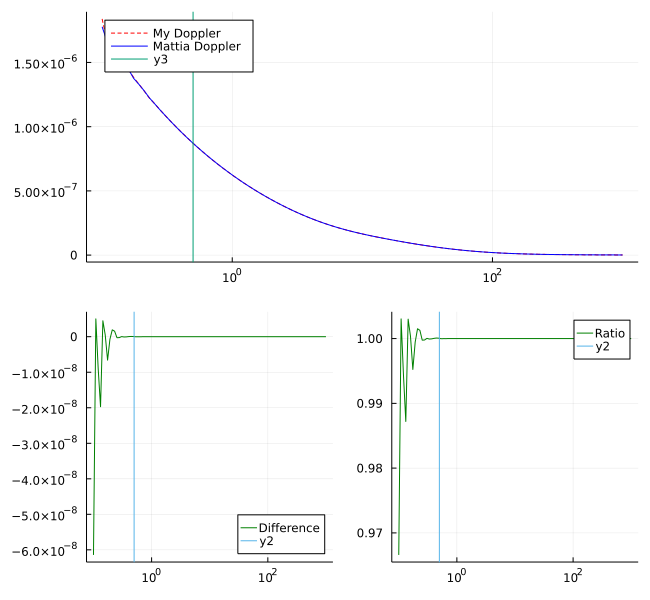

In [16]:
my_xs = my_ss
my_ys = xis
xs = my_ss
ys = calc_xis
spline = Spline1D(xs, ys)

S_VLIM=0.5

p1 = plot([my_xs, xs], [my_ys,  ys], xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], 
    label=["My Doppler" "Mattia Doppler"], ls=[:dash :solid], legend=:topleft)
vline!(p1, [S_VLIM])

p2 = plot(my_xs, spline.(my_xs) .- my_ys, 
    xaxis=:log,
    label="Difference", lc=:green, legend=:bottomright)
vline!(p2, [S_VLIM])

p3 = plot(my_xs, spline.(my_xs) ./ my_ys, label="Ratio", lc=:green, xaxis=:log,
    )#ylim=(0.99,1.01))
vline!(p3, [S_VLIM])

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )